In [1]:
%matplotlib inline

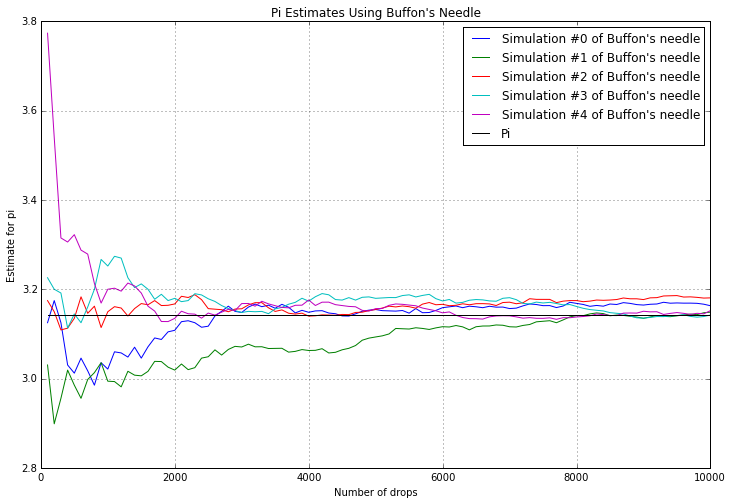

In [17]:
from numpy import random, pi, sin
import matplotlib.pyplot as plt

def drop_needle():
    """
    To estimate a single drop, it is sufficient to randomize a 
    location one end is dropped upon (between 0 and 1),
    an angle at which it is dropped, 
    and to then check if it crosses either 0 or 1.

    :return: True if the simulated needle crossed a line, False otherwise
    """
    start = random.uniform()
    angle = random.uniform() * 2 * pi
    end = start + sin(angle)

    return end <= 0 or end >= 1


def pi_from_simulation_results(drops, hits):
    """
    Estimate pi from simulation results
    :param drops: the number of drops performed
    :param hits: the number of hits observed in simulation
    :return: the estimation for pi from these results
    """
    return 2.0 * drops / hits


def buffons_needle_approximation(n):
    """
    Estimate pi using Buffon's needle procedure
    :param n: the number of needles to drop
    :return: the approximation of pi from those drops
    """
    hits = 0
    for _ in xrange(n):
        hits += drop_needle()

    return pi_from_simulation_results(n, hits)


def consecutive_buffons_needle_approximation(n_values):
    """
    Running estimate of pi using Buffon's needle procedure, 
    yielding values at every point in n_values
    :param n_values: the values of n to yield in
    :return: the approximation of pi from each n value drops
    """
    n = 0
    hits = 0

    for next_n in n_values:
        while n < next_n:
            hits += drop_needle()
            n += 1

        yield pi_from_simulation_results(n, hits)

        
def graph_consecutive_drops(n_values, number_of_simulations=3):
    plt.figure(figsize=(12, 8), dpi=400)
    
    for simulation in xrange(number_of_simulations):
        estimates = \
            [est for est in consecutive_buffons_needle_approximation(n_values)]    
        plt.plot(n_values, estimates, 
                 label="Simulation #{sim} of Buffon's needle".format(sim=simulation))

    plt.plot(n_values, [pi] * len(n_values), color='black', label="Pi")
    
    plt.grid(True)
    plt.title("Pi Estimates Using Buffon's Needle")
    plt.xlabel("Number of drops")
    plt.ylabel("Estimate for pi")
    plt.legend()
    
    plt.show()
        

def main():
    graph_consecutive_drops([100 * x for x in xrange(1, 101)], 5)

if __name__ == '__main__':
    main()